# 423 Final Project - PySpark - Matching

## Set-up

In [2]:
from pyspark.sql import SparkSession
import pandas as pd

In [4]:
#spark = SparkSession.builder.appName("local").getOrCreate()
spark = SparkSession\
        .builder\
        .config("spark.driver.memory", "4g")\
        .config("spark.executor.memory", "4g")\
        .getOrCreate()

23/06/02 12:30:49 WARN Utils: Your hostname, Shaolongs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.170.222 instead (on interface en0)
23/06/02 12:30:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/02 12:30:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
data = spark.read.format('csv').option('header', 'true').load('US_Traffic_v02.csv/*.csv')

In [28]:
# Select relevant features
cols_to_remove = ["Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Description", 
                  "Number", "Street", "Country", "Timezone", "Airport_Code", "Zipcode", 
                  "Weather_Timestamp", "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", 
                  "Astronomical_Twilight", "Weather_Condition", "Wind_Direction"]

df = data.select([col for col in data.columns if col not in cols_to_remove])

In [29]:
df.show(10)

+------+--------+--------------------+--------------------+------------------+----+-------------+----------+-----+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+----------+----------+-----------+-------------+------------------+--------+
|    ID|Severity|          Start_Time|            End_Time|      Distance(mi)|Side|         City|    County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Population|Start_Year|Start_Month|Start_Weekday|Start_TOD_Category|Duration|
+------+--------+--------------------+--------------------+------------------+----+-------------+----------+-----+--------------+-------------+-----------+-----

In [30]:
# Cast numeric columns to appropriate types
from pyspark.sql.functions import col

double_columns = ["Distance(mi)", "Temperature(F)", "Wind_Chill(F)", 
                   "Humidity(%)", "Pressure(in)", "Visibility(mi)", 
                   "Wind_Speed(mph)", "Precipitation(in)", "Duration"]

integer_columns = ["Population", "Start_Year", "Start_Month"]

for column in double_columns:
    df = df.withColumn(column, col(column).cast("double"))

for column in integer_columns:
    df = df.withColumn(column, col(column).cast("integer"))

In [31]:
# Remove one outlier row wither Side is "N"
df = df.where(df.Side != 'N')

In [32]:
# Encode binary categorical columns
from pyspark.sql.functions import when, col

binary_columns = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

for column in binary_columns:
    df = df.withColumn(column, when(col(column) == "true", 1).otherwise(0))

df = df.withColumn("Side", when(col("Side") == "L", 1).otherwise(0))

In [33]:
# Convert values in Start_TOD_Category column [Necessary for SMOTE]
from pyspark.sql.functions import when

df = df.withColumn("Start_TOD_Category",
                    when(df["Start_TOD_Category"] == "Midnight", "1")
                   .when(df["Start_TOD_Category"] == "Early Morning", "2")
                   .when(df["Start_TOD_Category"] == "Late Morning", "3")
                   .when(df["Start_TOD_Category"] == "Early Afternoon", "4")
                   .when(df["Start_TOD_Category"] == "Late Afternoon", "5")
                   .when(df["Start_TOD_Category"] == "Evening", "6"))

In [34]:
# One-Hot encode multi-class categorical columns
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# First convert the categories from 'string' to 'index'
indexer = StringIndexer(inputCol="Start_TOD_Category", outputCol="Start_TOD_Category_index")
df = indexer.fit(df).transform(df)

indexer = StringIndexer(inputCol="Start_Weekday", outputCol="Start_Weekday_index")
df = indexer.fit(df).transform(df)

# Then one-hot encode these indices
encoder = OneHotEncoder(inputCols=["Start_TOD_Category_index", "Start_Weekday_index"],
                        outputCols=["Start_TOD_Category_vec", "Start_Weekday_vec"])
model = encoder.fit(df)
df = model.transform(df)

In [35]:
df.show()

+------+--------+--------------------+--------------------+------------------+----+-------------+------------+-----+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+----------+----------+-----------+-------------+------------------+--------+------------------------+-------------------+----------------------+-----------------+
|    ID|Severity|          Start_Time|            End_Time|      Distance(mi)|Side|         City|      County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Population|Start_Year|Start_Month|Start_Weekday|Start_TOD_Category|Duration|Start_TOD_Category_index|Start_Weekday_index|Start_TOD_Category_vec|Start_W

In [36]:
df.dtypes

[('ID', 'string'),
 ('Severity', 'string'),
 ('Start_Time', 'string'),
 ('End_Time', 'string'),
 ('Distance(mi)', 'double'),
 ('Side', 'int'),
 ('City', 'string'),
 ('County', 'string'),
 ('State', 'string'),
 ('Temperature(F)', 'double'),
 ('Wind_Chill(F)', 'double'),
 ('Humidity(%)', 'double'),
 ('Pressure(in)', 'double'),
 ('Visibility(mi)', 'double'),
 ('Wind_Speed(mph)', 'double'),
 ('Precipitation(in)', 'double'),
 ('Amenity', 'int'),
 ('Bump', 'int'),
 ('Crossing', 'int'),
 ('Give_Way', 'int'),
 ('Junction', 'int'),
 ('No_Exit', 'int'),
 ('Railway', 'int'),
 ('Roundabout', 'int'),
 ('Station', 'int'),
 ('Stop', 'int'),
 ('Traffic_Calming', 'int'),
 ('Traffic_Signal', 'int'),
 ('Turning_Loop', 'int'),
 ('Population', 'int'),
 ('Start_Year', 'int'),
 ('Start_Month', 'int'),
 ('Start_Weekday', 'string'),
 ('Start_TOD_Category', 'string'),
 ('Duration', 'double'),
 ('Start_TOD_Category_index', 'double'),
 ('Start_Weekday_index', 'double'),
 ('Start_TOD_Category_vec', 'vector'),
 ('S

## Matching

#### **Precipitation(in)** [using df_1]

**1. Understanding Precipitation Distribution**

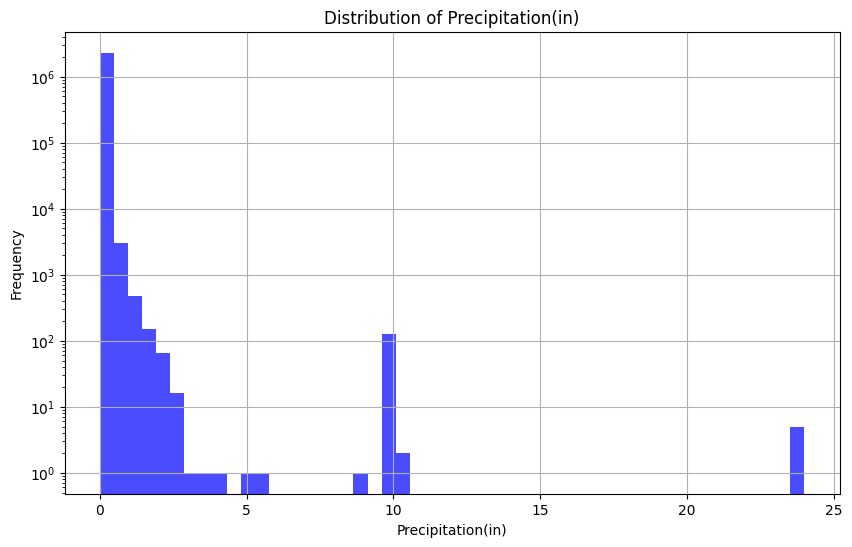

In [37]:
import matplotlib.pyplot as plt

# First, convert the precipitation data to a list in your local environment
precipitation_data = df.select('Precipitation(in)').dropna().rdd.flatMap(lambda x: x).collect()

# Now plot the data using matplotlib
plt.figure(figsize=(10,6))
plt.hist(precipitation_data, bins=50, color='blue', alpha=0.7)
plt.yscale('log', nonpositive='clip') # This line sets the y-axis to a logarithmic scale
plt.title('Distribution of Precipitation(in)')
plt.xlabel('Precipitation(in)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**2. Definitions**

1. Target column: Severity / Duration / Distance(mi)

2. Treatment&Control group:
    * treatment: precipitation >= 0.1 inch (including light, moderate, and heavy rain)
    * control: precipitation < 0.1 inch

    * How I selected the threshold? 
        * Source: https://www.weathershack.com/static/ed-rain-measurement.html#:~:text=Rainfall%20rate%20is%20generally%20described,inches%20of%20rain%20per%20hour
    
3. Covariates
    * Side, Wind_Chill(F), Pressure(in), Wind_Speed(mph), Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop, Traffic_Calming, Traffic_Signal, Turning_Loop, Population, Start_Weekday_vec, Start_TOD_Category_vec
    * Rationale: I don't want to choose variables that highly correlate with precipication. For example, visibility and humidity is almost a direct outcome of rain. I want to choose covariates that has almost nothing to do with precipitation. 
    * excluded: visibility, humidity, temperature

In [38]:
# Create the binary grouping variable of precipitation based on the definition
from pyspark.sql.functions import when

df_1 = df.withColumn('Rained', when(df['Precipitation(in)'] >= 0.1, 1).otherwise(0))

In [39]:
# Define the covariates
covariates_1 = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']

In [40]:
# Remove missing values in covariate columns
col_to_check = covariates_1
df_1 = df_1.na.drop(subset=col_to_check)

In [41]:
df_1.groupBy('Rained').count().show()

+------+-------+
|Rained|  count|
+------+-------+
|     1|  26751|
|     0|1847558|
+------+-------+



In [42]:
26751/(26751+1847558)

0.014272459877213416

Class imbalance is severe. Minority class is less than 1.5% of total. We need to apply balancing techniques.

**4. Undersampling Majority Class (No Rain) - Random undersampling** 1.5% --> 12.5%

In [43]:
from pyspark.sql import functions as F
# Create separate dataframes for the two classes
df_1_majority = df_1.filter(F.col("Rained") == 0)
df_1_minority = df_1.filter(F.col("Rained") == 1)

# Undersample the majority class
df_1_majority_sampled = df_1_majority.sample(withReplacement=False, fraction=0.1, seed=1)

# Concatenate the undersampled majority class dataframe and the minority class dataframe
df_1_undersample = df_1_minority.union(df_1_majority_sampled)

In [ ]:
from pyspark.sql import functions as F

# Undersample the majority class (0 class) using random sampling
df_0_undersampled = df_1.filter(F.col("Rained") == 0).sample(withReplacement=False, fraction=0.1, seed=1)

# Filter the minority class (1 class)
df_1_filtered = df_1.filter(F.col("Rained") == 1)

# Concatenate the undersampled majority class dataframe and the minority class dataframe
df_1_undersampled = df_1_filtered.union(df_0_undersampled)


In [44]:
df_1_undersample.show(5)

+------+--------+--------------------+--------------------+-------------------+----+--------------+------------+-----+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+----------+----------+-----------+-------------+------------------+--------+------------------------+-------------------+----------------------+-----------------+------+
|    ID|Severity|          Start_Time|            End_Time|       Distance(mi)|Side|          City|      County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Population|Start_Year|Start_Month|Start_Weekday|Start_TOD_Category|Duration|Start_TOD_Category_index|Start_Weekday_index|Start_TOD_Category_

In [46]:
26751/(184447+26751)

0.12666313127965226

**5. Oversampling Minority Class (Rain) with SMOTE** 12.6% --> 33.3%

In [47]:
# Define regular columns for SMOTE. Vector columns not allowed
covariates_1_forSMOTE = ['Severity', 'Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday', 'Start_TOD_Category']

In [48]:
covariates_1_forSMOTE_dis = ['Distance(mi)', 'Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday', 'Start_TOD_Category']

In [49]:
covariates_1_forSMOTE_dur = ['Duration', 'Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday', 'Start_TOD_Category']

In [50]:
# Apply SMOTE 
from imblearn.over_sampling import SMOTE

df_pd = df_1_undersample.toPandas()
X = df_pd[covariates_1_forSMOTE_dur]
y = df_pd["Rained"]

smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

df_res = pd.concat([X_res, y_res], axis=1)
#df_1_smoted = spark.createDataFrame(df_res)

In [51]:
df_res.head(10)

,Duration,Side,Wind_Chill(F),Pressure(in),Wind_Speed(mph),Amenity,Bump,Crossing,Give_Way,Junction,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Population,Start_Weekday,Start_TOD_Category,Rained
0,2.18,0,72.0,29.39,7.0,0,0,0,0,0,...,0,0,0,0,0,0,9686,2.0,4.0,1
1,5.90,0,72.0,28.88,6.0,0,0,0,0,0,...,0,0,0,0,0,0,12222,7.0,4.0,1
2,2.08,0,54.0,29.70,6.0,0,0,0,0,1,...,0,0,0,0,0,0,145163,5.0,3.0,1
3,1.29,0,65.0,29.79,3.0,0,0,0,0,1,...,0,0,0,0,0,0,9508,5.0,4.0,1
4,0.63,0,72.0,29.36,5.0,0,0,0,0,0,...,0,0,0,0,0,0,1098486,4.0,3.0,1
5,2.10,0,60.0,29.84,21.0,0,0,0,0,1,...,0,0,0,0,0,0,57139,3.0,3.0,1
6,1.33,0,46.0,29.43,6.0,0,0,0,0,1,...,0,0,0,0,0,0,4137,3.0,3.0,1
7,2.39,0,23.0,24.70,12.0,0,0,0,0,0,...,0,0,0,0,0,0,3354,5.0,5.0,1
8,0.56,0,74.0,29.63,0.0,0,0,0,0,0,...,0,0,0,0,0,0,44950,5.0,4.0,1
9,1.34,1,72.0,29.40,7.0,0,0,1,0,0,...,0,0,0,0,1,0,1516107,4.0,6.0,1


In [53]:
df_res.shape

(276670, 22)

In [418]:
# Round synthethic Severity estiamtion to integer
from pyspark.sql.functions import round
df_1_smoted = df_1_smoted.withColumn("Distance(mi)", round(df_1_smoted["Distance(mi)"]).cast("double"))

In [419]:
df_1_smoted.groupBy("Rained").count().show()

23/06/01 20:48:35 WARN TaskSetManager: Stage 36 contains a task of very large size (2471 KiB). The maximum recommended task size is 1000 KiB.


+------+------+
|Rained| count|
+------+------+
|     0|184447|
|     1| 92223|
+------+------+



In [420]:
df_1_smoted.count()

23/06/01 20:48:39 WARN TaskSetManager: Stage 39 contains a task of very large size (2471 KiB). The maximum recommended task size is 1000 KiB.


276670

In [421]:
92223/(92223+184447)

0.33333212852857197

In [422]:
df_1_smoted.show(5)

+------------+----+-------------+------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+----------+-------------+------------------+------+
|Distance(mi)|Side|Wind_Chill(F)|Pressure(in)|Wind_Speed(mph)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Population|Start_Weekday|Start_TOD_Category|Rained|
+------------+----+-------------+------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+----------+-------------+------------------+------+
|         1.0|   0|         72.0|       29.39|            7.0|      0|   0|       0|       0|       0|      0|      0|         0|      0|   0|              0|             0|           0|      9686|          2.0|               4.0|     1|
|         0.0|   0|         72.0|       28.88|  

23/06/01 20:48:45 WARN TaskSetManager: Stage 42 contains a task of very large size (2471 KiB). The maximum recommended task size is 1000 KiB.


In [423]:
# One-Hot encode the multi-class columns again
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# First convert the categories from 'string' to 'index'
indexer = StringIndexer(inputCol="Start_TOD_Category", outputCol="Start_TOD_Category_index")
df_1_smoted = indexer.fit(df_1_smoted).transform(df_1_smoted)

indexer = StringIndexer(inputCol="Start_Weekday", outputCol="Start_Weekday_index")
df_1_smoted = indexer.fit(df_1_smoted).transform(df_1_smoted)

# Then one-hot encode these indices
encoder = OneHotEncoder(inputCols=["Start_TOD_Category_index", "Start_Weekday_index"],
                        outputCols=["Start_TOD_Category_vec", "Start_Weekday_vec"])
model = encoder.fit(df_1_smoted)
df_1_balanced = model.transform(df_1_smoted)

23/06/01 20:48:48 WARN TaskSetManager: Stage 43 contains a task of very large size (2471 KiB). The maximum recommended task size is 1000 KiB.
23/06/01 20:48:48 WARN TaskSetManager: Stage 46 contains a task of very large size (2471 KiB). The maximum recommended task size is 1000 KiB.


In [424]:
df_1_balanced.show(5)

+------------+----+-------------+------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+----------+-------------+------------------+------+------------------------+-------------------+----------------------+-----------------+
|Distance(mi)|Side|Wind_Chill(F)|Pressure(in)|Wind_Speed(mph)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Population|Start_Weekday|Start_TOD_Category|Rained|Start_TOD_Category_index|Start_Weekday_index|Start_TOD_Category_vec|Start_Weekday_vec|
+------------+----+-------------+------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+----------+-------------+------------------+------+------------------------+-------------------+----------------------+-----------------+
|         1.0|   0|         

23/06/01 20:49:01 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/06/01 20:49:01 WARN TaskSetManager: Stage 49 contains a task of very large size (2471 KiB). The maximum recommended task size is 1000 KiB.


In [425]:
df_1_balanced.groupBy("Rained").count().show()

+------+------+
|Rained| count|
+------+------+
|     0|184447|
|     1| 92223|
+------+------+



23/06/01 20:49:13 WARN TaskSetManager: Stage 50 contains a task of very large size (2471 KiB). The maximum recommended task size is 1000 KiB.


**6. Estimating PSM**

In [426]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Define the covariates
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']

# Assemble features with VectorAssembler
assembler = VectorAssembler(inputCols=covariates, outputCol="features")

# Define the logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='Rained', maxIter=10)

# Define the pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Fit the model
model = pipeline.fit(df_1_balanced)

# Predict and add the propensity scores to the DataFrame
df_1_balanced = model.transform(df_1_balanced).select('Distance(mi)', 'Rained', 'features', 'probability')

# Extract the probability of treatment (i.e., the propensity score)
extract_prob = udf(lambda x: float(x[1]), FloatType())
df_1_balanced = df_1_balanced.withColumn("propensity_score", extract_prob('probability'))

23/06/01 20:49:25 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
23/06/01 20:49:25 WARN TaskSetManager: Stage 53 contains a task of very large size (2471 KiB). The maximum recommended task size is 1000 KiB.
23/06/01 20:49:26 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
23/06/01 20:49:26 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
23/06/01 20:49:26 WARN TaskSetManager: Stage 55 contains a task of very large size (2471 KiB). The maximum recommended task size is 1000 KiB.
23/06/01 20:49:27 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
23/06/01 20:49:27 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
23/06/01 20:49:27 WARN TaskSetManager: Stage 57 contains a task of very large size (2471 KiB). The maximum recommended task size is 1000 KiB.
23/06/01 20:49:27 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
23/06/01 20:49:28 WARN DAGScheduler: Broadcasting large ta

In [427]:
df_1_balanced.show(5)

23/06/01 20:49:48 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
23/06/01 20:49:48 WARN TaskSetManager: Stage 79 contains a task of very large size (2471 KiB). The maximum recommended task size is 1000 KiB.


+------------+------+--------------------+--------------------+----------------+
|Distance(mi)|Rained|            features|         probability|propensity_score|
+------------+------+--------------------+--------------------+----------------+
|         1.0|     1|(65368,[1,2,3,17,...|[0.75407753637193...|      0.24592246|
|         0.0|     1|(65368,[1,2,3,17,...|[0.84469838918575...|      0.15530162|
|         1.0|     1|(65368,[1,2,3,8,1...|[0.78933248634955...|      0.21066752|
|         0.0|     1|(65368,[1,2,3,8,1...|[0.82799822889367...|      0.17200176|
|         0.0|     1|(65368,[1,2,3,17,...|[0.79972381341507...|      0.20027618|
+------------+------+--------------------+--------------------+----------------+
only showing top 5 rows



In [429]:
df_pd_dis = df_1_balanced.toPandas()

23/06/01 20:52:47 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
23/06/01 20:52:47 WARN TaskSetManager: Stage 80 contains a task of very large size (2471 KiB). The maximum recommended task size is 1000 KiB.


In [432]:
df_pd_dis.shape

(276670, 5)

**7. Matching**

In [433]:
from sklearn.neighbors import NearestNeighbors

# Set caliper value
caliper = 0.05

# Create two dataframes for treatment and control groups
df_treatment = df_pd_dis[df_pd_dis['Rained'] == 1]
df_control = df_pd_dis[df_pd_dis['Rained'] == 0]

# Fit nearest neighbors model to control group
nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

# Find nearest neighbors in control group for each treatment case
distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

# Create dataframe of distances and indices
matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                        'treatment_index': df_treatment.index})

# Apply caliper: only keep pairs where the distance is below the caliper
matches = matches[matches['distance'] <= caliper]

# Merge data from treatment and control cases into the matches dataframe
matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
    .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))

In [434]:
matched_pairs

,distance,control_index,treatment_index,Distance(mi)_treatment,Rained_treatment,features_treatment,probability_treatment,propensity_score_treatment,Distance(mi)_control,Rained_control,features_control,probability_control,propensity_score_control
0,1.326203e-06,65583,0,1.0,1,"(0.0, 72.0, 29.39, 7.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.7540775363719394, 0.24592246362806058]",0.245922,0.0,0,"(1.0, 68.0, 29.36, 5.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.8387156730262755, 0.16128432697372452]",0.161284
30932,1.326203e-06,65583,215379,2.0,1,"(0.0, 72.0, 29.39, 7.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.7540775363719394, 0.24592246362806058]",0.245922,0.0,0,"(1.0, 68.0, 29.36, 5.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.8387156730262755, 0.16128432697372452]",0.161284
1,1.534820e-06,78981,1,0.0,1,"(0.0, 72.0, 28.88, 6.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.844698389185752, 0.15530161081424798]",0.155302,3.0,0,"(0.0, 77.0, 28.96, 6.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.8238753319929216, 0.17612466800707838]",0.176125
2770,1.534820e-06,78981,2770,0.0,1,"(0.0, 72.0, 28.88, 6.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.844698389185752, 0.15530161081424798]",0.155302,3.0,0,"(0.0, 77.0, 28.96, 6.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.8238753319929216, 0.17612466800707838]",0.176125
26652,1.534820e-06,78981,26652,0.0,1,"(0.0, 72.0, 28.88, 6.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.844698389185752, 0.15530161081424798]",0.155302,3.0,0,"(0.0, 77.0, 28.96, 6.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.8238753319929216, 0.17612466800707838]",0.176125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92169,2.682209e-07,71907,276616,0.0,1,"(0.0, 76.41432212568309, 29.95, 5.951406724590...","[0.7210901664883166, 0.2789098335116834]",0.278910,2.0,0,"(0.0, 71.0, 30.02, 12.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.7145260441959995, 0.2854739558040005]",0.285474
92178,3.516674e-06,137421,276625,1.0,1,"(0.0, 37.654431096847844, 29.674285198749285, ...","[0.6705523235180666, 0.3294476764819334]",0.329448,3.0,0,"(0.0, 74.0, 29.61, 18.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.7451716447435022, 0.25482835525649783]",0.254828
92189,4.291534e-06,162272,276636,1.0,1,"(0.0, 51.69346797400287, 29.7, 10.0, 0.0, 0.0,...","[0.5989960767587071, 0.40100392324129286]",0.401004,0.0,0,"(1.0, 42.0, 29.92, 3.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.91515249756618, 0.08484750243382]",0.084848
92204,2.980232e-08,68964,276651,7.0,1,"(0.0, 56.0, 29.7, 2.6103536635445477, 0.0, 0.0...","[0.720507509439109, 0.279492490560891]",0.279492,1.0,0,"(0.0, 75.0, 29.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.8335198706356716, 0.16648012936432843]",0.166480


In [435]:
matched_pairs.dtypes

distance                      float64
control_index                   int64
treatment_index                 int64
Distance(mi)_treatment        float64
Rained_treatment                int64
features_treatment             object
probability_treatment          object
propensity_score_treatment    float32
Distance(mi)_control          float64
Rained_control                  int64
features_control               object
probability_control            object
propensity_score_control      float32
dtype: object

In [325]:
matched_pairs['propensity_score_treatment'].max()

0.9998923

In [326]:
threshold = 0.9
matched_pairs_filtered = matched_pairs[matched_pairs['propensity_score_treatment'] <= threshold]

In [327]:
matched_pairs_filtered.head()

,distance,control_index,treatment_index,Severity_treatment,Rained_treatment,features_treatment,probability_treatment,propensity_score_treatment,Severity_control,Rained_control,features_control,probability_control,propensity_score_control,treatment_effect
0,4.768372e-07,134822,0,2.0,1,"(0.0, 72.0, 29.39, 7.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.7529469961409027, 0.24705300385909734]",0.247053,2.0,0,"(1.0, 46.0, 30.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.9166328811681598, 0.08336711883184023]",0.083367,0.0
30932,4.768372e-07,134822,215379,2.0,1,"(0.0, 72.0, 29.39, 7.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.7529469961409027, 0.24705300385909734]",0.247053,2.0,0,"(1.0, 46.0, 30.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.9166328811681598, 0.08336711883184023]",0.083367,0.0
1,7.450581e-08,140307,1,2.0,1,"(0.0, 72.0, 28.88, 6.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.8440668007234595, 0.15593319927654048]",0.155933,2.0,0,"(0.0, 91.0, 29.84, 5.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.7640806059537161, 0.23591939404628393]",0.235919,0.0
2770,7.450581e-08,140307,2770,4.0,1,"(0.0, 72.0, 28.88, 6.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.8440668007234595, 0.15593319927654048]",0.155933,2.0,0,"(0.0, 91.0, 29.84, 5.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.7640806059537161, 0.23591939404628393]",0.235919,2.0
26652,7.450581e-08,140307,26652,2.0,1,"(0.0, 72.0, 28.88, 6.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.8440668007234595, 0.15593319927654048]",0.155933,2.0,0,"(0.0, 91.0, 29.84, 5.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.7640806059537161, 0.23591939404628393]",0.235919,0.0


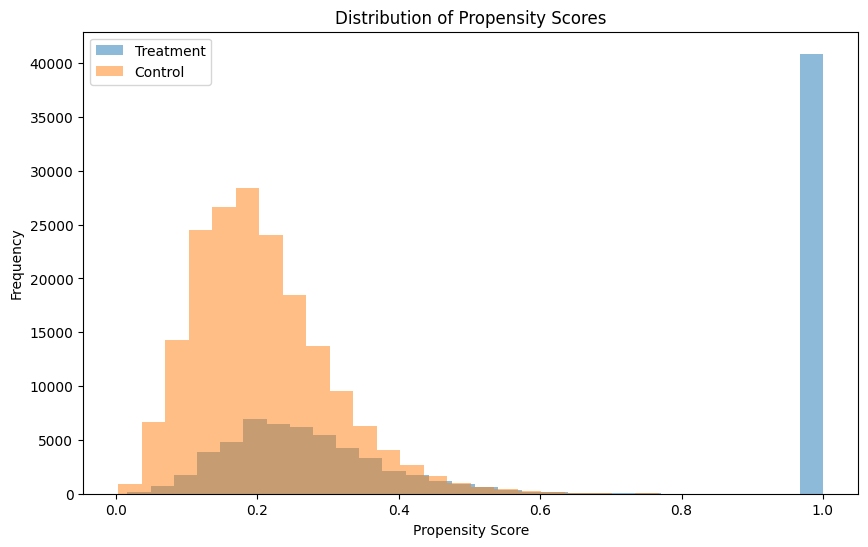

In [321]:
import matplotlib.pyplot as plt

# Plot the distribution of propensity scores for treatment and control groups
plt.figure(figsize=(10, 6))
plt.hist(df_pd[df_pd['Rained'] == 1]['propensity_score'], bins=30, alpha=0.5, label='Treatment')
plt.hist(df_pd[df_pd['Rained'] == 0]['propensity_score'], bins=30, alpha=0.5, label='Control')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Propensity Scores')
plt.legend()
plt.show()

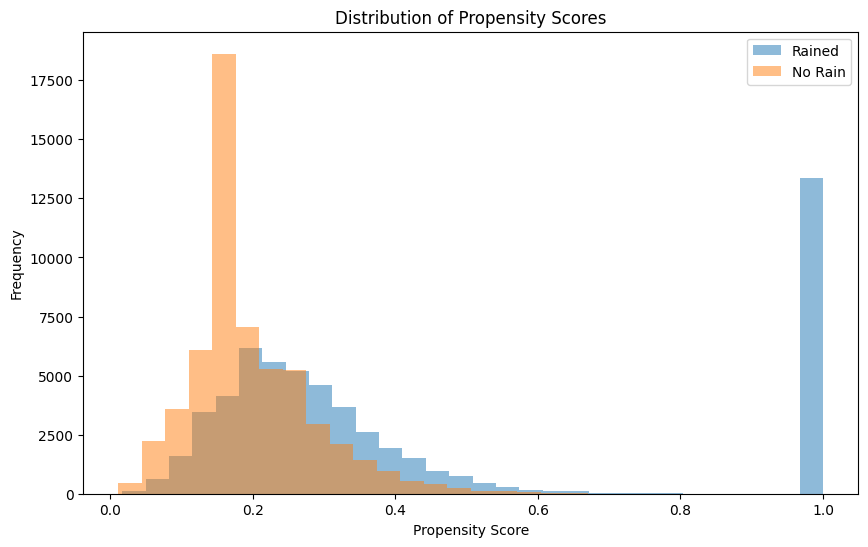

In [436]:
import matplotlib.pyplot as plt

# Extract propensity scores for treatment and control
propensity_scores_treatment = matched_pairs['propensity_score_treatment']
propensity_scores_control = matched_pairs['propensity_score_control']

# Plot the distribution of propensity scores
plt.figure(figsize=(10, 6))
plt.hist(propensity_scores_treatment, bins=30, alpha=0.5, label='Rained')
plt.hist(propensity_scores_control, bins=30, alpha=0.5, label='No Rain')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Propensity Scores')
plt.legend()
plt.show()

**8. Calculate the Average Treatment Effect**

In [438]:
matched_pairs['treatment_effect'] = matched_pairs['Distance(mi)_treatment'] - matched_pairs['Distance(mi)_control']
average_treatment_effect = matched_pairs['treatment_effect'].mean()

In [439]:
print(average_treatment_effect)

0.2142832283437163


23/06/02 00:02:31 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 993713 ms exceeds timeout 120000 ms
23/06/02 00:02:31 WARN SparkContext: Killing executors is not supported by current scheduler.
23/06/02 00:02:37 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

In [328]:
matched_pairs_filtered['treatment_effect'] = matched_pairs_filtered['Severity_treatment'] - matched_pairs['Severity_control']
average_treatment_effect = matched_pairs_filtered['treatment_effect'].mean()

/var/folders/6f/nrypv02913b7t6kz9bv3cy6c0000gn/T/ipykernel_78809/2794132524.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_pairs_filtered['treatment_effect'] = matched_pairs_filtered['Severity_treatment'] - matched_pairs['Severity_control']


In [329]:
print(average_treatment_effect)

0.005218227175977846


#### **Population** [using df_2]

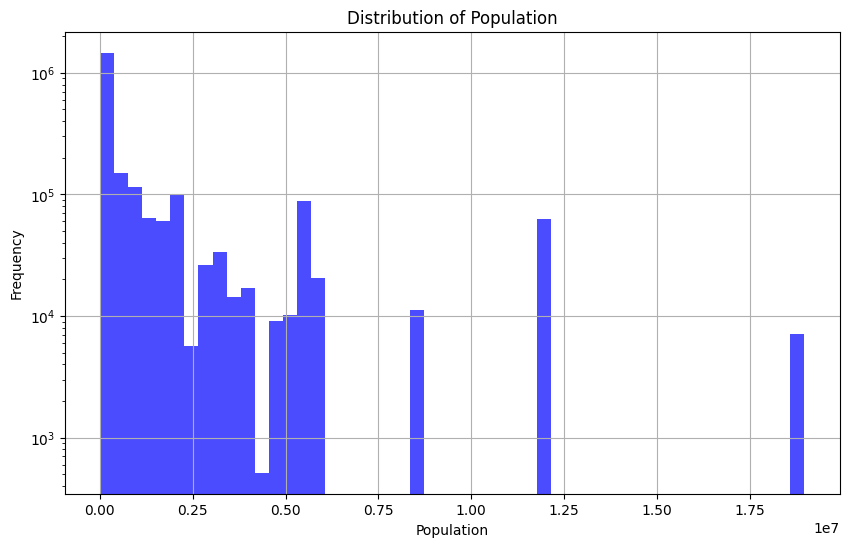

In [235]:
import matplotlib.pyplot as plt

# First, convert the precipitation data to a list in your local environment
precipitation_data = df.select('Population').dropna().rdd.flatMap(lambda x: x).collect()

# Now plot the data using matplotlib
plt.figure(figsize=(10,6))
plt.hist(precipitation_data, bins=50, color='blue', alpha=0.7)
plt.yscale('log', nonpositive='clip') # This line sets the y-axis to a logarithmic scale
plt.title('Distribution of Population')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [242]:
# Assuming you have a DataFrame called 'df' and the column you want to calculate the median is 'column_name'
pop_median = df.stat.approxQuantile('Population', [0.5], 0)[0]
pop_average = df.agg(F.avg('Population')).first()[0]

In [15]:
from pyspark.sql import functions as F
rain_median = df.stat.approxQuantile('Precipitation(in)', [0.5], 0)[0]
rain_average = df.agg(F.avg('Precipitation(in)')).first()[0]

In [17]:
print(round(rain_median, 5))

print(rain_average)

0.0
0.007016939880237001


In [243]:
print(pop_median)

print(pop_average)

105086.0
1191700.8103668096


1. Target column: Severity / Duration / Distance(mi)

2. Treatment&Control group:
    * treatment: population >= median (large cities)
    * control: population < median (small cities)
    
3. Covariates
    * Side, Temperature(F), Wind_Chill(F), Humidity(%), Pressure(in), Visibility(mi), Wind_Speed(mph), Precipitation(in), Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop, Traffic_Calming, Traffic_Signal, Turning_Loop, Start_Weekday_vec, Start_TOD_Category_vec
    

In [244]:
# Create the binary grouping variable of precipitation based on the definition
from pyspark.sql.functions import when
df_2 = df.withColumn('City_Size', when(df['Population'] >= pop_median, 1).otherwise(0))

In [245]:
df_2.groupBy("City_Size").count().show()

+---------+-------+
|City_Size|  count|
+---------+-------+
|        1|1130434|
|        0|1714907|
+---------+-------+



In [249]:
# Define the covariates
covariates_2 = ['Side', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
                'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Start_Weekday_vec', 'Start_TOD_Category_vec']

In [250]:
col_to_check_2 = covariates_2
df_2 = df_2.na.drop(subset=col_to_check_2)

In [251]:
df_2.groupBy("City_Size").count().show()

+---------+-------+
|City_Size|  count|
+---------+-------+
|        1| 873368|
|        0|1341160|
+---------+-------+



In [252]:
873368/(873368+1341160)

0.39438110513843133

Treatment group is 40% of the total dataset. This is mild imbalance. We can accept this and move forward. 

In [256]:
df_2.show(5)

+------+--------+--------------------+--------------------+------------------+----+-------------+----------+-----+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+----------+----------+-----------+-------------+------------------+--------+------------------------+-------------------+----------------------+-----------------+---------+
|    ID|Severity|          Start_Time|            End_Time|      Distance(mi)|Side|         City|    County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Population|Start_Year|Start_Month|Start_Weekday|Start_TOD_Category|Duration|Start_TOD_Category_index|Start_Weekday_index|Start_TOD_Category_vec|S

In [257]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import expr, col

In [258]:
df_2.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Side: integer (nullable = false)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Amenity: integer (nullable = false)
 |-- Bump: integer (nullable = false)
 |-- Crossing: integer (nullable = false)
 |-- Give_Way: integer (nullable = false)
 |-- Junction: integer (nullable = false)
 |-- No_Exit: integer (nullable = false)
 |-- Railway: integer (nullable = false)
 |-- Roundabout: integer (nullable = fa

In [259]:
selected_columns = ["Severity", "City_Size"] + covariates_2
df_2_selected = df_2.select(selected_columns)

In [273]:
df_2_selected.show(5)

+--------+---------+----+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+-----------------+----------------------+
|Severity|City_Size|Side|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Start_Weekday_vec|Start_TOD_Category_vec|
+--------+---------+----+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+-----------------+----------------------+
|       2|        0|   1|          70.0|         70.0|       53.0|       29.41|          10.0|           14.0|        

In [278]:
# Creating a feature vector using VectorAssembler
assembler = VectorAssembler(inputCols=covariates_2, outputCol="features")
#feature_vec = assembler.transform(df_2_selected).select("features", "City_Size", "Severity")

In [279]:
from pyspark.ml import Pipeline
# Splitting the data into training and test sets
train_data, test_data = df_2_selected.randomSplit([0.7, 0.3], seed=42)

# Training a logistic regression model to estimate propensity scores
lr = LogisticRegression(featuresCol="features", labelCol="City_Size", maxIter=10)

pipeline = Pipeline(stages=[assembler, lr])

model = pipeline.fit(train_data)

# Generating propensity scores on the test data
propensity_scores = model.transform(test_data).select("Severity", "City_Size", "features", "probability")

In [280]:
propensity_scores.show()

+--------+---------+--------------------+--------------------+
|Severity|City_Size|            features|         probability|
+--------+---------+--------------------+--------------------+
|       2|        0|(32,[1,2,3,4,5,6,...|[0.83463463595601...|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.78273924335493...|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.80638845475602...|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.80653244029730...|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.83612912231669...|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.87898259549031...|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.80956303524965...|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.78832062478247...|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.78832062478247...|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.71021466087040...|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.71021466087040...|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.83369188227020...|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.81617868024

In [284]:
from pyspark.sql.functions import udf

# Create a UDF to extract the values from the probability column
extract_prob = udf(lambda x: float(x[1]), FloatType())

# Calculate the propensity score
propensity_scores = propensity_scores.withColumn("propensity_score", extract_prob('probability'))

In [285]:
propensity_scores.show(5)

+--------+---------+--------------------+--------------------+----------------+
|Severity|City_Size|            features|         probability|propensity_score|
+--------+---------+--------------------+--------------------+----------------+
|       2|        0|(32,[1,2,3,4,5,6,...|[0.83463463595601...|      0.16536537|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.78273924335493...|      0.21726076|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.80638845475602...|      0.19361155|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.80653244029730...|      0.19346756|
|       2|        0|(32,[1,2,3,4,5,6,...|[0.83612912231669...|      0.16387087|
+--------+---------+--------------------+--------------------+----------------+
only showing top 5 rows



In [287]:
df_pd = propensity_scores.toPandas()

In [299]:
len(df_pd)

664322

In [288]:
df_pd.head(10)

,Severity,City_Size,features,probability,propensity_score
0,2,0,"(0.0, -19.0, -40.0, 73.0, 28.52, 10.0, 10.0, 0...","[0.8346346359560103, 0.16536536404398972]",0.165365
1,2,0,"(0.0, -19.0, -19.0, 79.0, 28.69, 10.0, 3.0, 0....","[0.7827392433549373, 0.21726075664506272]",0.217261
2,2,0,"(0.0, -18.0, -33.0, 81.0, 28.59, 10.0, 6.0, 0....","[0.8063884547560249, 0.19361154524397506]",0.193612
3,2,0,"(0.0, -17.0, -35.0, 80.0, 28.63, 10.0, 8.0, 0....","[0.8065324402973031, 0.1934675597026969]",0.193468
4,2,0,"(0.0, -16.0, -35.0, 82.0, 28.5, 10.0, 9.0, 0.0...","[0.8361291223166939, 0.1638708776833061]",0.163871
5,2,0,"(0.0, -16.0, -16.0, 91.0, 25.02, 8.0, 3.0, 0.0...","[0.8789825954903177, 0.12101740450968235]",0.121017
6,2,0,"(0.0, -15.0, -38.0, 64.0, 29.06, 10.0, 14.0, 0...","[0.8095630352496506, 0.19043696475034944]",0.190437
7,2,0,"(0.0, -13.0, -30.0, 75.0, 28.87, 10.0, 8.0, 0....","[0.7883206247824797, 0.21167937521752034]",0.211679
8,2,0,"(0.0, -13.0, -30.0, 75.0, 28.87, 10.0, 8.0, 0....","[0.7883206247824797, 0.21167937521752034]",0.211679
9,2,0,"(0.0, -13.0, -30.0, 75.0, 28.87, 10.0, 8.0, 0....","[0.7102146608704087, 0.28978533912959126]",0.289785


In [289]:
from sklearn.neighbors import NearestNeighbors

# Set caliper value
caliper = 0.05

# Create two dataframes for treatment and control groups
df_treatment = df_pd[df_pd['City_Size'] == 1]
df_control = df_pd[df_pd['City_Size'] == 0]

# Fit nearest neighbors model to control group
nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

# Find nearest neighbors in control group for each treatment case
distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

# Create dataframe of distances and indices
matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                        'treatment_index': df_treatment.index})

# Apply caliper: only keep pairs where the distance is below the caliper
matches = matches[matches['distance'] <= caliper]

# Merge data from treatment and control cases into the matches dataframe
matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
    .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))

In [300]:
len(matched_pairs)

171387

In [290]:
matched_pairs.head(10)

,distance,control_index,treatment_index,Severity_treatment,City_Size_treatment,features_treatment,probability_treatment,propensity_score_treatment,Severity_control,City_Size_control,features_control,probability_control,propensity_score_control
2,4.470348e-08,358966,48123,2,1,"(0.0, -3.0, -19.0, 75.0, 28.98, 10.0, 9.0, 0.0...","[0.759045218254235, 0.240954781745765]",0.240955,2,0,"(0.0, 40.0, 33.0, 89.0, 29.7, 2.0, 10.0, 0.0, ...","[0.657045965797876, 0.342954034202124]",0.342954
3,1.370907e-06,308089,48124,2,1,"(0.0, -2.0, -12.0, 76.0, 28.75, 10.0, 5.0, 0.0...","[0.7973156226600199, 0.20268437733998013]",0.202684,2,0,"(1.0, 64.0, 64.0, 52.0, 29.74, 10.0, 7.0, 0.0,...","[0.5993029243769603, 0.4006970756230397]",0.400697
71623,1.370907e-06,308089,233436,2,1,"(0.0, -2.0, -12.0, 76.0, 28.75, 10.0, 5.0, 0.0...","[0.7973156226600199, 0.20268437733998013]",0.202684,2,0,"(1.0, 64.0, 64.0, 52.0, 29.74, 10.0, 7.0, 0.0,...","[0.5993029243769603, 0.4006970756230397]",0.400697
4,0.000000e+00,54,48125,2,1,"(0.0, -1.0, -1.0, 62.0, 29.13, 10.0, 0.0, 0.0,...","[0.7545856276551625, 0.24541437234483754]",0.245414,2,0,"(0.0, -1.0, -1.0, 62.0, 29.13, 10.0, 0.0, 0.0,...","[0.7545856276551625, 0.24541437234483754]",0.245414
8,4.962087e-06,313215,48129,2,1,"(0.0, 4.0, -8.0, 64.0, 29.07, 10.0, 7.0, 0.0, ...","[0.787763545415234, 0.21223645458476603]",0.212236,2,0,"(1.0, 88.0, 88.0, 61.0, 30.04, 10.0, 12.0, 0.0...","[0.6167543960505304, 0.3832456039494696]",0.383246
9,1.043081e-06,212912,48130,2,1,"(0.0, 4.0, 4.0, 84.0, 29.12, 6.0, 0.0, 0.0, 0....","[0.7326358764246643, 0.2673641235753357]",0.267364,2,0,"(0.0, 77.0, 77.0, 78.0, 29.75, 10.0, 10.0, 0.0...","[0.5979597929636724, 0.4020402070363276]",0.402040
11,8.195639e-07,213351,48132,2,1,"(0.0, 6.0, -9.0, 53.0, 29.3, 10.0, 10.0, 0.0, ...","[0.7539620293472399, 0.24603797065276012]",0.246038,2,0,"(0.0, 78.0, 78.0, 37.0, 29.68, 8.0, 6.0, 0.0, ...","[0.5405406269386624, 0.45945937306133755]",0.459459
13,3.904104e-06,312172,48134,2,1,"(0.0, 8.0, -4.0, 76.0, 26.45, 5.0, 8.0, 0.0, 0...","[0.8281126357443993, 0.1718873642556007]",0.171887,2,0,"(1.0, 82.0, 82.0, 79.0, 29.99, 10.0, 6.0, 0.0,...","[0.4888367294556743, 0.5111632705443256]",0.511163
223814,5.513430e-07,312172,567779,3,1,"(0.0, 32.0, 25.0, 92.0, 24.61, 10.0, 7.0, 0.0,...","[0.8281159899659238, 0.17188401003407616]",0.171884,2,0,"(1.0, 82.0, 82.0, 79.0, 29.99, 10.0, 6.0, 0.0,...","[0.4888367294556743, 0.5111632705443256]",0.511163
14,5.662441e-07,368649,48135,2,1,"(0.0, 8.0, -3.0, 71.0, 28.74, 10.0, 6.0, 0.0, ...","[0.762262475495694, 0.23773752450430596]",0.237738,2,0,"(0.0, 53.0, 53.0, 71.0, 30.15, 10.0, 0.0, 0.0,...","[0.5725710392233657, 0.4274289607766343]",0.427429


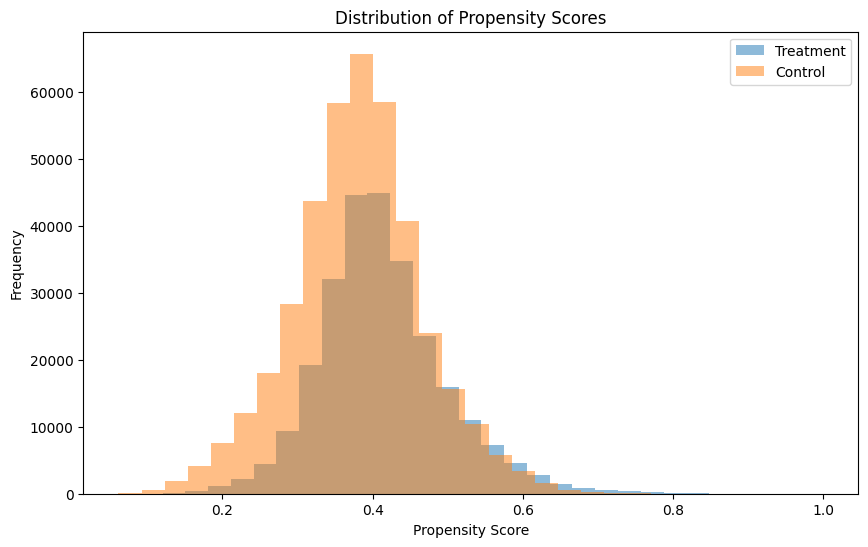

In [301]:
import matplotlib.pyplot as plt

# Plot the distribution of propensity scores for treatment and control groups
plt.figure(figsize=(10, 6))
plt.hist(df_pd[df_pd['City_Size'] == 1]['propensity_score'], bins=30, alpha=0.5, label='Treatment')
plt.hist(df_pd[df_pd['City_Size'] == 0]['propensity_score'], bins=30, alpha=0.5, label='Control')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Propensity Scores')
plt.legend()
plt.show()

In [305]:
matched_pairs.dtypes

distance                      float64
control_index                   int64
treatment_index                 int64
Severity_treatment             object
City_Size_treatment             int32
features_treatment             object
probability_treatment          object
propensity_score_treatment    float32
Severity_control               object
City_Size_control               int32
features_control               object
probability_control            object
propensity_score_control      float32
dtype: object

In [307]:
import pandas as pd

# Convert Severity_treatment and Severity_control columns to numeric type
matched_pairs['Severity_treatment'] = matched_pairs['Severity_treatment'].astype(float)
matched_pairs['Severity_control'] = matched_pairs['Severity_control'].astype(float)

In [308]:
matched_pairs.dtypes

distance                      float64
control_index                   int64
treatment_index                 int64
Severity_treatment            float64
City_Size_treatment             int32
features_treatment             object
probability_treatment          object
propensity_score_treatment    float32
Severity_control              float64
City_Size_control               int32
features_control               object
probability_control            object
propensity_score_control      float32
dtype: object

In [312]:
matched_pairs['treatment_effect'] = matched_pairs['Severity_treatment'] - matched_pairs['Severity_control']

In [316]:
matched_pairs['treatment_effect'].mean()

0.015240362454561897